# Spotify Recommendation System - Experimentation Notebook

This notebook provides a complete framework for training, evaluating, and visualizing a baseline collaborative filtering model for song recommendations.

## 1. Setup

Install and import necessary libraries. We add `matplotlib` for plotting.

In [2]:
!pip install pandas scikit-learn tqdm matplotlib


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import json
import os
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

## 2. Experiment Tracking Setup

We'll create a list to store the results of each experiment. This will allow us to easily compare runs and plot the outcomes.

In [4]:
experiment_results = []

## 3. Core Functions (Data Loading, Evaluation)

These are the helper functions for loading data and calculating our evaluation metrics.

In [5]:
# Loads one or more JSON slice files from the dataset.
# 'path' is the absolute path to the 'data' folder of the MPD.
# 'slice_nums' is a list of slice indices (e.g., [0] → playlists 0–999, [0,1] → 0–1999).
def load_playlist_slice(path, slice_nums=[0]):
    all_playlists = []
    for slice_num in slice_nums:
        filename = f'mpd.slice.{slice_num*1000}-{(slice_num+1)*1000-1}.json'
        try:
            with open(os.path.join(path, filename)) as f:
                data = json.load(f)
                all_playlists.extend(data['playlists'])
        except FileNotFoundError:
            print(f"Warning: Slice file not found at {os.path.join(path, filename)}. Skipping.")
    return all_playlists


# Precision@k:
# "Out of the top 'k' recommendations, how many were actually relevant?"
# 'recommendations' → items your model suggested.
# 'holdout_items' → actual items the user liked.
def precision_at_k(k, recommendations, holdout_items):
    recs_at_k = recommendations[:k]
    hits = len(set(recs_at_k) & set(holdout_items))
    return hits / k


# Recall@k:
# "Of all the relevant items, what proportion did we find?"
def recall_at_k(k, recommendations, holdout_items):
    recs_at_k = recommendations[:k]
    hits = len(set(recs_at_k) & set(holdout_items))
    return hits / len(holdout_items) if len(holdout_items) > 0 else 0


## 4. Experiment Runner

This is the main function that encapsulates the entire process: data loading, preprocessing, training, and evaluation. It takes your parameters, runs the experiment, and stores the results.

In [6]:
def run_experiment(slice_nums, n_components, k=10): #k here generates 10 songs
    """Runs a full experiment cycle with given parameters and stores the results."""
    
    # --- 1. Data Loading & Preprocessing ---
    print(f"Loading {len(slice_nums)} slice(s) of data...")
    data_path = '/Users/pabil/Downloads/spotify_million_playlist_dataset/data/'
    playlists = load_playlist_slice(data_path, slice_nums=slice_nums)
    if not playlists:
        print("No data loaded. Aborting experiment.")
        return

    all_tracks = [track['track_uri'] for p in playlists for track in p['tracks']]
    unique_tracks = sorted(list(set(all_tracks)))
    track_to_idx = {track: i for i, track in enumerate(unique_tracks)}
    idx_to_track = {i: track for track, i in track_to_idx.items()}
    pid_to_idx = {p['pid']: i for i, p in enumerate(playlists)}

    # Create train-test split
    rows, cols, test_set = [], [], {}
    for p in playlists:
        playlist_idx = pid_to_idx[p['pid']]
        tracks = [t['track_uri'] for t in p['tracks']]
        if len(tracks) > 5:
            np.random.shuffle(tracks)
            num_holdout = int(len(tracks) * 0.2)
            test_set[playlist_idx] = [uri for uri in tracks[-num_holdout:] if uri in track_to_idx]
            train_tracks = tracks[:-num_holdout]
        else:
            train_tracks = tracks
        for track_uri in train_tracks:
            if track_uri in track_to_idx:
                rows.append(playlist_idx)
                cols.append(track_to_idx[track_uri])

    interaction_matrix_train = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(len(playlists), len(unique_tracks)))

    # --- 2. Model Training ---
    print(f"Training SVD model with n_components={n_components}...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    playlist_embeddings = svd.fit_transform(interaction_matrix_train)
    track_embeddings = svd.components_.T

    # --- 3. Evaluation ---
    print(f"Evaluating model with k={k}...")
    knn = NearestNeighbors(n_neighbors=k*2, metric='cosine').fit(track_embeddings)
    avg_precision = 0
    avg_recall = 0
    eval_count = 0

    for user_idx, holdout_items in tqdm(test_set.items(), desc="Evaluating"):
        input_track_indices = interaction_matrix_train[user_idx].indices
        if len(input_track_indices) == 0 or len(holdout_items) == 0:
            continue

        playlist_vector = np.mean(track_embeddings[input_track_indices], axis=0).reshape(1, -1)
        distances, indices = knn.kneighbors(playlist_vector, n_neighbors=k + len(input_track_indices))
        
        recommendations = []
        train_uris = {idx_to_track[i] for i in input_track_indices}
        for idx in indices.flatten():
            rec_uri = idx_to_track[idx]
            if rec_uri not in train_uris:
                recommendations.append(rec_uri)
        
        avg_precision += precision_at_k(k, recommendations[:k], holdout_items)
        avg_recall += recall_at_k(k, recommendations[:k], holdout_items)
        eval_count += 1

    avg_precision /= eval_count
    avg_recall /= eval_count
    
    print(f"Precision@{k}: {avg_precision:.4f}, Recall@{k}: {avg_recall:.4f}")

    # --- 4. Store Results ---
    experiment_results.append({
        'slice_nums': slice_nums,
        'data_size': len(playlists),
        'n_components': n_components,
        f'precision_at_{k}': avg_precision,
        f'recall_at_{k}': avg_recall
    })
    print("--- Experiment Complete ---\n")

## 5. Run Experiments

Now you can easily run multiple experiments by calling the `run_experiment` function with different parameters. We'll loop through a few values for `n_components` to see how it affects performance.

In [7]:
# Clear previous results before starting a new set of experiments
experiment_results = []

# Define the set of n_components values to test
component_options = [60]


# --- Experiment Set 1: Train on 10,000 playlists (slices 0–9) ---
print("--- Starting experiments on n playlists (1 slice is 1k playlists) ---")

slices_for_playlists = list(range(15))  # slices 0–9

# Run experiments for each n_components value
for n_comps in component_options:
    run_experiment(slice_nums=slices_for_playlists, n_components=n_comps, k=10)


# --- Experiment Set 2: Train on 100,000 playlists (slices 0–99) ---
# WARNING: This will take a very long time and require a lot of memory.
## print("\n--- Starting experiments on 100,000 playlists (100 slices) ---")

## slices_for_100k_playlists = list(range(100))  # slices 0–99

## for n_comps in component_options:
    ## run_experiment(slice_nums=slices_for_100k_playlists, n_components=n_comps, k=10)




--- Starting experiments on n playlists (1 slice is 1k playlists) ---
Loading 15 slice(s) of data...
Training SVD model with n_components=60...
Evaluating model with k=10...


Evaluating: 100%|██████████| 13931/13931 [05:10<00:00, 44.92it/s]


Precision@10: 0.0400, Recall@10: 0.0366
--- Experiment Complete ---



# Testing data

## Testing at 5k slices from 50-80 components
- 50 --> Precision@10: 0.0322, Recall@10: 0.0304 
- 60 --> Precision@10: 0.0327, Recall@10: 0.0309 
- 70 --> Precision@10: 0.0300, Recall@10: 0.0293  
- 80 --> Precision@10: 0.0294, Recall@10: 0.0287 

Seems to be degrading between 60-70 

## Testing at 10k slices from 50-80 components
- 50 --> Precision@10: 0.0380, Recall@10: 0.0349
- 60 --> Precision@10: 0.0391, Recall@10: 0.0368
- 70 --> Precision@10: 0.0390, Recall@10: 0.0359 
- 80 --> Precision@10: 0.0391, Recall@10: 0.0355

## Testing at 5k slices from  60, 61, 62, 63, 64, 69 components
- 60 --> Precision@10: 0.0320, Recall@10: 0.0309
- 61 --> Precision@10: 0.0324, Recall@10: 0.0319
- 62 --> Precision@10: 0.0332, Recall@10: 0.0322
- 63 --> Precision@10: 0.0319, Recall@10: 0.0299
- 64 --> Precision@10: 0.0317, Recall@10: 0.0306  
- 69 --> Precision@10: 0.0307, Recall@10: 0.0292

## Testing at 10k slices from  60, 61, and 62 components
- 60 --> Precision@10: 0.0405, Recall@10: 0.0373
- 61 --> Precision@10: 0.0387, Recall@10: 0.0358
- 62 --> Precision@10: 0.0391, Recall@10: 0.0357

60 is overall the ideal amount of latent factors as it provides the best recall and precision overall.

## Testing at 50k slices from  60 components
- 60 --> Precision@10: 0.0401, Recall@10: 0.0367
- seems like we got more noise, with 60 comps, ideal pl size is 10k

## Testing at 20k slices from  60 components
- 60 --> Precision@10: 0.0412, Recall@10: 0.0377

## Testing at 15k slices from  60 components
- 60 --> Precision@10: 0.0414, Recall@10: 0.0379

## 6. Visualize Results

After the experiments are complete, we can convert our results list into a pandas DataFrame and plot the outcome to easily see the impact of our changes.

Experiment Results:
                                          slice_nums  data_size  n_components  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      14000            60   

   precision_at_10  recall_at_10  
0          0.03999      0.036584  


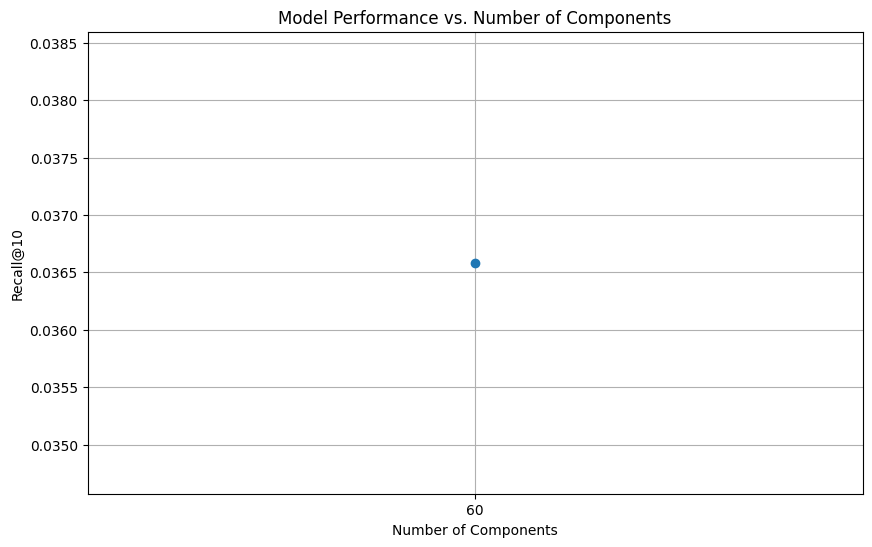

In [8]:
if not experiment_results:
    print("No experiment results to plot. Please run some experiments first.")
else:
    results_df = pd.DataFrame(experiment_results)
    print("Experiment Results:")
    print(results_df)
    
    # Plotting Recall vs. n_components
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['n_components'], results_df['recall_at_10'], marker='o')
    plt.title('Model Performance vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Recall@10')
    plt.grid(True)
    plt.xticks(results_df['n_components'])
    plt.show()

# 7. Save Model

In [11]:
# --- CONFIGURATION FOR FINAL MODEL ---
# Based on your decision to use 15k playlists and our finding that 60 components is optimal.
BEST_N_COMPONENTS = 60
SLICES_TO_TRAIN_ON = list(range(15)) # This will use 15,000 playlists

# --- 1. Load Data and Mappings ---
# This step is similar to the experiment runner, but we don't create a test set.
# We use all available data for training to make the final model as powerful as possible.
print(f"Loading data from {len(SLICES_TO_TRAIN_ON)} slices for final training...")
data_path = '/Users/pabil/Downloads/spotify_million_playlist_dataset/data/'
playlists = load_playlist_slice(data_path, slice_nums=SLICES_TO_TRAIN_ON)

print("Creating final data mappings and interaction matrix...")
all_tracks = [track['track_uri'] for p in playlists for track in p['tracks']]
unique_tracks = sorted(list(set(all_tracks)))
track_to_idx = {track: i for i, track in enumerate(unique_tracks)}
idx_to_track = {i: track for track, i in track_to_idx.items()}
pid_to_idx = {p['pid']: i for i, p in enumerate(playlists)}

rows, cols = [], []
for p in playlists:
    playlist_idx = pid_to_idx[p['pid']]
    for track in p['tracks']:
        if track['track_uri'] in track_to_idx:
            rows.append(playlist_idx)
            cols.append(track_to_idx[track['track_uri']])

interaction_matrix = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(len(playlists), len(unique_tracks)))

# --- 2. Train Final Models ---
print(f"Training final SVD model with n_components={BEST_N_COMPONENTS}...")
final_svd = TruncatedSVD(n_components=BEST_N_COMPONENTS, random_state=42)
final_svd.fit(interaction_matrix) # Fit on the full interaction matrix for these slices

print("Training final KNN model...")
track_embeddings = final_svd.components_.T
final_knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute').fit(track_embeddings)

# --- 3. Save Artifacts using joblib ---
# joblib is generally more efficient for saving large numpy arrays, which is what our models are.
print("Saving model artifacts to .pkl files...")
joblib.dump(final_svd, 'svd_model.pkl')
joblib.dump(final_knn, 'knn_model.pkl')
joblib.dump(track_to_idx, 'track_to_idx.pkl')
joblib.dump(idx_to_track, 'idx_to_track.pkl')

print("\nArtifacts saved successfully!")
print("Remember to move these .pkl files from 'notebooks' to your '/model' directory.")

Loading data from 15 slices for final training...
Creating final data mappings and interaction matrix...
Training final SVD model with n_components=60...
Training final KNN model...
Saving model artifacts to .pkl files...

Artifacts saved successfully!
Remember to move these .pkl files from 'notebooks' to your '/model' directory.
